In [1]:
# Standard imports
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline

from time import time

# PyREx imports
from pyrex.digsig import SlowAskaryanSignal, FastAskaryanSignal, ThermalNoise

In [8]:
# Signal plotting helper function
def plot_sig(signal, alternate_values=None, zoom=None, figsize=(6,4)):
    plt.figure(figsize=figsize)
    if alternate_values is not None:
        values = alternate_values
    else:
        values = signal.values
    if zoom is not None:
        ts = []
        vs = []
        for t,v in zip(signal.times,values):
            if t<zoom[0]:
                continue
            elif t>zoom[1]:
                break
            ts.append(t)
            vs.append(v)
        plt.plot(np.array(ts)*1e9, vs)
    else:
        plt.plot(signal.times*1e9, values)
    plt.xlabel("Time (ns)")

## Jump to:

[Test Slow Askaryan Pulses](#slow_askaryan_pulses)

[Test Faster Askaryan Pulses](#fast_askaryan_pulses)

[Test Thermal (Rayleigh) Noise](#thermal_noise)

<a id='slow_askaryan_pulses'></a>
# Test Slow Askaryan Pulses

Make signal object

In [8]:
times = np.linspace(0, 100e-9, 10001)
n = 1.75
theta_c = np.arcsin(np.sqrt(1 - 1/n**2))
angle = theta_c - 0.3*np.pi/180 # radians
# angle = 45*np.pi/180
print("angle =",angle*180/np.pi,"degrees")
energy = 3e6 # TeV
t0 = 25e-9 # seconds
start_time = time()
ask = SlowAskaryanSignal(times, energy=energy, theta=angle, t0=t0, n=n)
end_time = time()
print("Generating an Askaryan pulse with",len(times),"points took", end_time-start_time, "seconds")
print(round((end_time-start_time)/len(times)*1000,2),"ms per time point")

angle = 54.850095421 degrees
Generating an Askaryan pulse with 10001 points took 111.61066794395447 seconds
11.16 ms per time point


First make sure that the longitudinal shower profile makes sense

Integral:  2.29306854455e-09


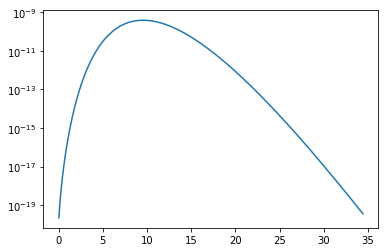

In [9]:
z_min = 0
z_max = 2.5*ask.max_length()
n_z = 1000
z_vals, dz = np.linspace(z_min, z_max, n_z, endpoint=False, retstep=True)
Q = np.zeros(n_z)
for i, z in enumerate(z_vals):
    Q[i] = ask.charge_profile(z)
plt.semilogy(z_vals, Q)
print("Integral: ", np.trapz(Q, dx=dz))

Next check the RAC distribution

Should peak around 1e-5 with the normalization factor applied. Width should be about .5 ns at 1e-6 and 1 ns at 1e-7

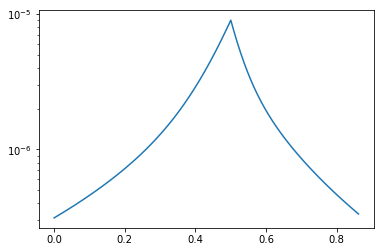

In [10]:
t = 25.5e-9
z_to_t = -(1 - n*np.cos(angle))/3e8
RA_C = np.zeros(n_z)
for j, z in enumerate(z_vals):
    RA_C[j] = ask.RAC(t - t0 - z*z_to_t)
normalization = 1e8 / energy
plt.semilogy(z_vals*z_to_t*1e9, -1*RA_C*normalization)

Now check the vector potential

For a 3 EeV shower 0.3 degrees off the Cherenkov angle, expect a peak around 7e-8 volt-seconds and a width of about 3 ns

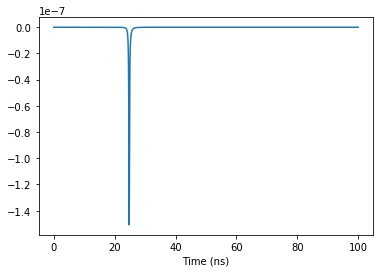

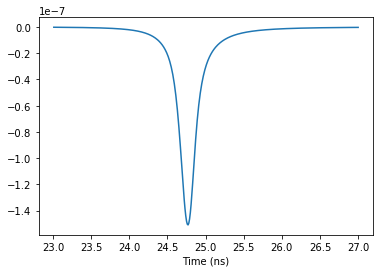

In [11]:
plot_sig(ask, alternate_values=ask.vec_pot)
plot_sig(ask, alternate_values=ask.vec_pot, zoom=[23e-9,27e-9])

Finally, check that the waveform looks correct

For a 3 EeV shower 0.3 degrees of the Cherenkov angle, expect an amplitude of about 200 volts (when multiplied by R, assumed to be 1 meter in the signal code anyway) and a width of about 1 ns

832.621044624


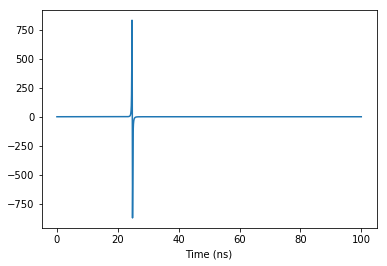

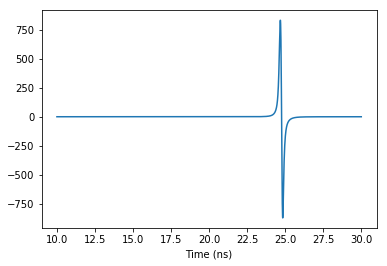

In [14]:
plot_sig(ask)
plot_sig(ask, zoom=[10e-9,30e-9])
# plt.figure()
# plt.plot(np.linspace(0,100e-9,5001),scipy.signal.resample(ask.values,5001))
print(max(ask.values))

<a id='fast_askaryan_pulses'></a>
# Test Faster Askaryan Pulses

Make signal object

In [9]:
times = np.linspace(0, 100e-9, 10001, endpoint=True)
n = 1.75
theta_c = np.arcsin(np.sqrt(1 - 1/n**2))
angle = theta_c - 0.3*np.pi/180 # radians
# angle = 45*np.pi/180
print("angle =",angle*180/np.pi,"degrees")
energy = 3e6 # TeV
t0 = 25e-9 # seconds
start_time = time()
ask = FastAskaryanSignal(times, energy=energy, theta=angle, t0=t0, n=n)
end_time = time()
print("Generating an Askaryan pulse with",len(times),"points took", end_time-start_time, "seconds")
print(round((end_time-start_time)/len(times)*1e6,2),"microseconds per time point")

angle = 54.850095421 degrees
Generating an Askaryan pulse with 10001 points took 0.11767005920410156 seconds
11.77 microseconds per time point


Check the shower profile and RAC distributions, as well as their convolution

z_to_t = -2.50195760286e-11
dz = 0.399687028612
n_Q = 86
LQ_tot = 2.29306854452e-09


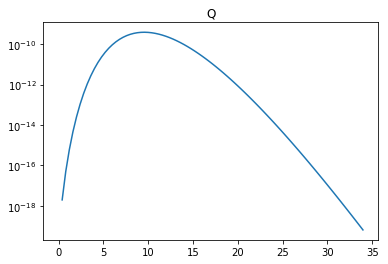

n_RAC = 9916


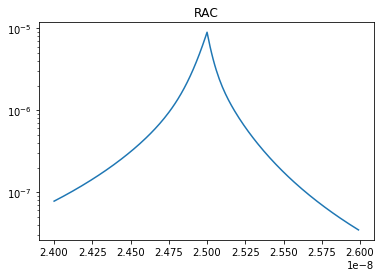

10001 == 10001 ?


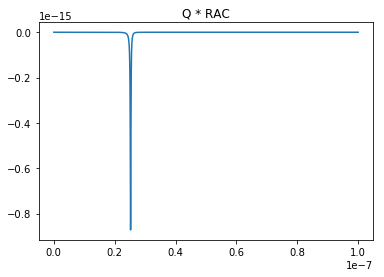

In [10]:
# Conversion factor for z in RAC
z_to_t = (1 - n*np.cos(angle))/3e8
print("z_to_t =",z_to_t)

dt = times[1] - times[0]
dz = np.abs(dt / z_to_t)
print("dz =",dz)

z_max = 2.5*ask.max_length()
n_Q = int(z_max/dz)
print("n_Q =",n_Q)
z_Q_vals = np.arange(n_Q) * dz
Q = np.zeros(n_Q)
for i, z in enumerate(z_Q_vals):
    Q[i] = ask.charge_profile(z)
LQ_tot = np.trapz(Q, dx=dz)
print("LQ_tot =", LQ_tot)

plt.semilogy(z_Q_vals, Q)
plt.title("Q")
plt.show()

n_RAC = len(times) + 1 - n_Q
print("n_RAC =",n_RAC)
z_RAC_vals = np.arange(n_RAC) * dz
RA_C = np.zeros(n_RAC)
for i, z in enumerate(z_RAC_vals):
    RA_C[i] = ask.RAC(t0 + z*z_to_t)

normalization = 1e8 / energy
plt.semilogy(z_RAC_vals[2400:2600]*-z_to_t, -1*RA_C[2400:2600]*normalization)
plt.title("RAC")
plt.show()

conv = scipy.signal.convolve(Q, RA_C, mode='full')
print(len(times),"==",len(conv),"?")
plt.plot(times, conv)
plt.title("Q * RAC")
plt.show()

Now check the vector potential

For a 3 EeV shower 0.3 degrees off the Cherenkov angle, expect a peak around 7e-8 volt-seconds and a width of about 3 ns

10001 10001
True


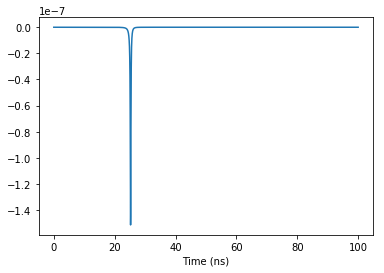

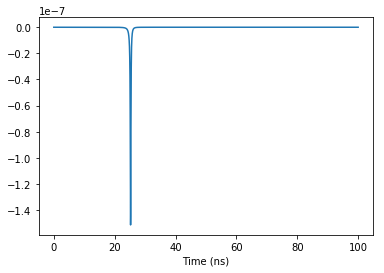

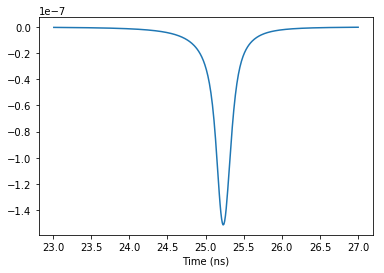

In [16]:
plot_sig(ask, alternate_values=ask.vector_potential)
plot_sig(ask, alternate_values=ask.vector_potential, zoom=[23e-9,27e-9])

Finally, check that the waveform looks correct

For a 3 EeV shower 0.3 degrees of the Cherenkov angle, expect an amplitude of about 200 volts (when multiplied by R, assumed to be 1 meter in the signal code anyway) and a width of about 2 ns

878.099054363


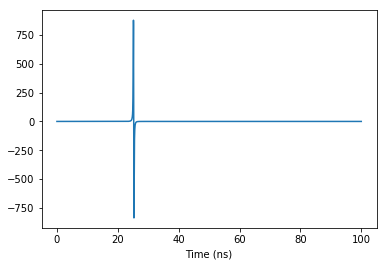

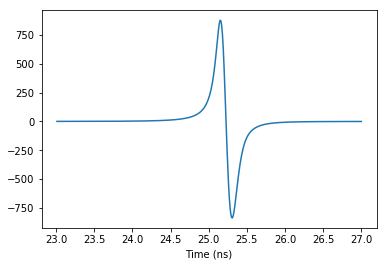

In [18]:
plot_sig(ask)
plot_sig(ask, zoom=[23e-9,27e-9])
print(max(ask.values))

<a id='thermal_noise'></a>
# Test Thermal (Rayleigh) Noise

Compare noise to the examples in the ANITA paper (linked in source code)

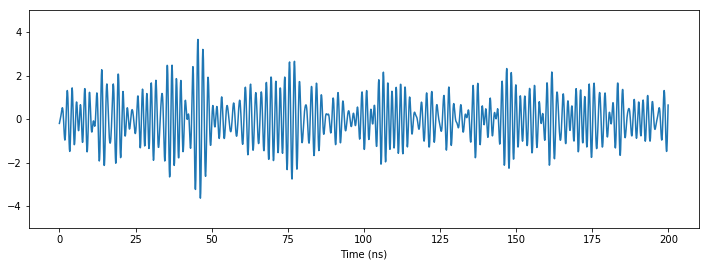

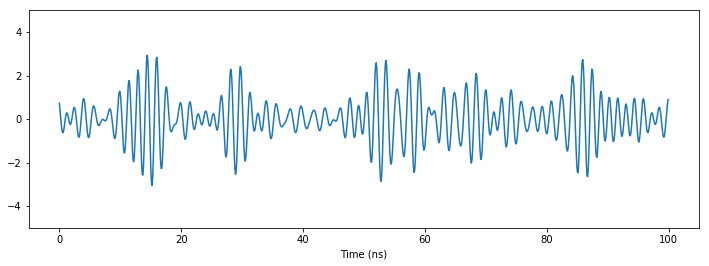

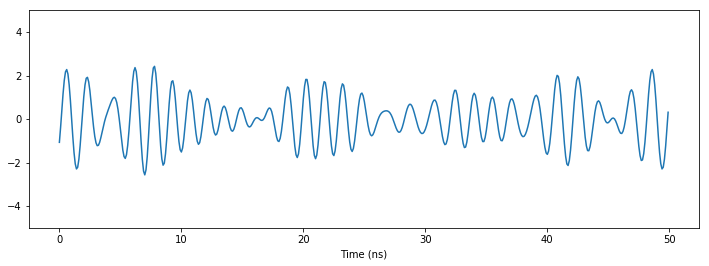

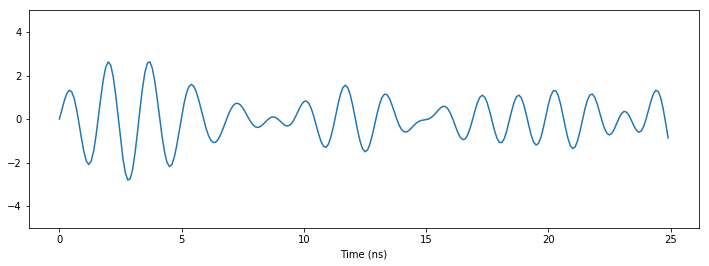

In [21]:
temp = 300
f_band = [500e6, 750e6]
# Calculate resistance to give v_rms=1 so amplitudes can be compared directly to ANITA paper
res = 1 / (4*1.38e-23*temp*(f_band[1]-f_band[0]))
dt = 0.1e-9

shape = (12,4)
noise1 = ThermalNoise(np.arange(2000)*dt, temp, res, f_band)
plot_sig(noise1, figsize=shape)
plt.axes().set_ylim(-5,5)

noise2 = ThermalNoise(np.arange(1000)*dt, temp, res, f_band)
plot_sig(noise2, figsize=shape)
plt.axes().set_ylim(-5,5)

noise3 = ThermalNoise(np.arange(500)*dt, temp, res, f_band)
plot_sig(noise3, figsize=shape)
plt.axes().set_ylim(-5,5)

noise4 = ThermalNoise(np.arange(250)*dt, temp, res, f_band)
plot_sig(noise4, figsize=shape)
plt.axes().set_ylim(-5,5)

long_noise = ThermalNoise(np.arange(100000)*dt, temp, res, f_band)

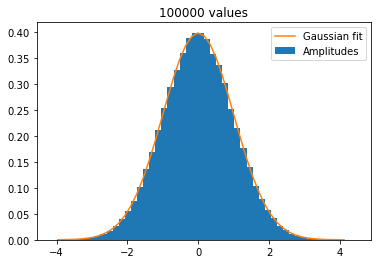

In [24]:
hist = plt.hist(long_noise.values, bins=50, normed=True, label="Amplitudes")
std_norm = lambda x: np.exp(-x**2 / 2) / np.sqrt(2*np.pi)
plt.plot(hist[1][1:-2], [std_norm(x) for x in hist[1][1:-2]], label="Gaussian fit")
plt.title(str(len(long_noise.values))+" values")
plt.legend()
plt.show()

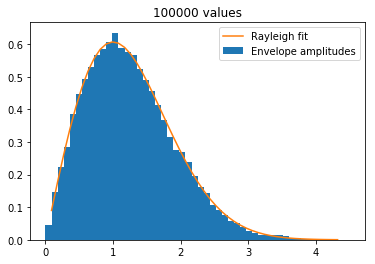

In [25]:
hist = plt.hist(long_noise.envelope, bins=50, normed=True, label="Envelope amplitudes")
rayleigh = lambda x: x * np.exp(-x**2 / 2)
plt.plot(hist[1][1:-2], [rayleigh(x) for x in hist[1][1:-2]], label="Rayleigh fit")
plt.title(str(len(long_noise.values))+" values")
plt.legend()
plt.show()